# Relax Challenge

A number of factors are relevant in predicting whether a customer will adopt a product.  Based on the data provided, I attempt to determine the most relevant factors and the extent to which they contribute to customer adoption of the given product. 

Note: This section contains the entirety of this report. Each section is also viewable separately in context with the code below this section.  

## Data Cleaning

I began by loading and viewing the two relevant datasets, noting where any NA/Null values occurred.  There were no NA's in the user_engage dataset. In the users dataset, the two columns with NA/Null values were last_session_creation_time and invited_by_user_id.  It was not necessary to handle the nulls in invited_by_user_id, since some users were not invited, so I proceeded to the last_session_creation_time column.  

I imputed the same value from the creation_time column to the missing values in the last_session_creation_time column since for those users who only logged in once, the creation time would be the same as their last session creation time. I then had to convert the creation_time and last_session_creation_time columns in the users dataframe and the time_stamp column in the user_engage dataframe to datetime types.  

After making the time_stamp column in user_engage a datetime index, I then grouped the dataframe by user_id, resampled by week and counted the number of visits in order to identify the numbers of visits per week for each user.  

I then filtered the new dataframe (__engage__) created by this grouping and resampling to obtain the user id's for those individuals with 3 or more visits per week and unindexed the user_id column, storing these results in another dataframe called __engaged__. 

The engaged dataframe was then used to create a dictionary engage_dict to map user_id's (also appearing in the users dataframe) to 1's.  This dictionary was then used to create the new binary adopted_user variable in the users dataframe, 1's representing users that visited 3 or more times in a week, 0's representing those who did not.  

## Statistical Analysis

Out of 12,000 users, 1,445 were adopted users within this definition, or approximately 12%. 

More adopted users appear to come from organizational invites than from other sources, although this is also true of non-adopted users as well. In fact, a greater percentage come from organizational invites among the non-adopters than from among the adopters (35.65% vs. 33.98%), so the influence of this as a source is likely negligible. However, the percentage of guest invites were the highest among the adopted users and were also greater than the percentage from among non-adopted users (22.56% adopted vs. 17.40% not adopted). The number of guest invites may therefore be a possible predictor for adopted users. 

Slightly more people that are adopted users opted in to the mailing list than non-adopters (26.16% vs. 24.78%).  Mail list opt-ins may therefore be a predictor for adopted users, though perhaps not a significant one.  

Slightly more people that are adopted users were enabled for the marketing drip than non-adopters (15.50% vs. 14.86%).  Given that this is such a small difference (less than 1%), the influence of the marketing drip may be negligible.  

## Machine Learning

### Initial preparations

In order to prepare the data for use in a machine learning model, I extracted some additional features from the last_session_creation_time variable, namely the months the users last logged in (called month_logged_in), and whether it was in the am or pm hours of the day (am_pm, a binary variable). Slightly over 50% of users last logged in during pm hours, rather than am hours. 

I then determined that the invited_by_user_id category was unnecessary to include, noting that it was only null for those creation_sources that were not guest or organizational invites, so provided creation_source was included as a variable, invited_by_user_id would be unlikely to add any useful additional information.  

Finally, I converted the creation_source and month_logged_in categorical variables to dummy variables and included the following variables in the feature variables to be used in the model:  creation_source, month_logged_in, opted_in_to_mailing_list, enabled_for_marketing_drip and am_pm.  Adopted_user was used as the target variable.  

The feature and target variables were then split into training and test variables using an 80%-20% train-test split.

### Random Forest Classifier

I then created a simple Random Forest Classifier using 100 estimators to which I fit the training data.  It yielded a reasonably good accuracy of 86.79% on the test data.  

I then extracted the feature_importances which revealed that the two most important features in determining product adoption were logins in the months of June and May (month_logged_in_6 and month_logged_in_5, in that order). Of additional, though lesser, importance were (in descending order of importance):  opt-ins to the mailing list, creation sources from personal projects, whether the individuals were enabled for the marketing drip and whether the last log in was during am or pm hours. 

## Conclusions

In conclusion, it appears that the last month logged in appears to be the best predictor of user adoption of the product.  

From one perspective, the best times to target customers may be in the months of June and May during pm hours, as these are the times that users who adopt the product are most likely to have last logged in. Conversely, it could also be argued that the other months should be targeted more, since these are the times when those who are less likely to adopt appear to have last logged in.  Perhaps additional customer outreach during these times might serve to increase adoption rates during these months.   

It also appears that customers should be encouraged to opt in to the mailing list and enable themselves for the marketing drip, since adoption of the product appears to be slightly more likely in these cases.  Finally, based on the statistical analysis above, customers who signed up as a result of guest invites may also be slightly more likely to adopt the product, although this did not appear to be a strongly influential factor. 


## Data Cleaning

I began by loading and viewing the two relevant datasets, noting where any NA/Null values occurred.  There were no NA's in the user_engage dataset. In the users dataset, the two columns with NA/Null values were last_session_creation_time and invited_by_user_id.  It was not necessary to handle the nulls in invited_by_user_id, since some users were not invited, so I proceeded to the last_session_creation_time column.  

In [1]:
import numpy as np
import pandas as pd

users = pd.read_csv('takehome_users.csv', encoding='latin-1')
users.info()
users.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 10 columns):
object_id                     12000 non-null int64
creation_time                 12000 non-null object
name                          12000 non-null object
email                         12000 non-null object
creation_source               12000 non-null object
last_session_creation_time    8823 non-null float64
opted_in_to_mailing_list      12000 non-null int64
enabled_for_marketing_drip    12000 non-null int64
org_id                        12000 non-null int64
invited_by_user_id            6417 non-null float64
dtypes: float64(2), int64(4), object(4)
memory usage: 937.6+ KB


,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [2]:
user_engage = pd.read_csv('takehome_user_engagement.csv', encoding='latin-1')

user_engage.info()
user_engage.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207917 entries, 0 to 207916
Data columns (total 3 columns):
time_stamp    207917 non-null object
user_id       207917 non-null int64
visited       207917 non-null int64
dtypes: int64(2), object(1)
memory usage: 4.8+ MB


,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


In [3]:
#Compare creation_time and last_session_creation_time--need to convert to datetime types
print(type(users.creation_time[0]))

print(type(users.last_session_creation_time[0]))


<class 'str'>
<class 'numpy.float64'>


In [4]:
#Convert creation_time str type to datetime 
users.creation_time = pd.to_datetime(users.creation_time)


In [5]:
#Convert last_session_creation_time str type to datetime
users.last_session_creation_time = pd.to_datetime(users.last_session_creation_time, unit='s')


In [6]:
#Display null values for last_session_creation_time

users[pd.isnull(users['last_session_creation_time'])]

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
7,8,2013-07-31 05:34:02,Hamilton Danielle,DanielleHamilton@yahoo.com,PERSONAL_PROJECTS,NaT,1,1,74,NaN
8,9,2013-11-05 04:04:24,Amsel Paul,PaulAmsel@hotmail.com,PERSONAL_PROJECTS,NaT,0,0,302,NaN
11,12,2014-04-17 23:48:38,Mathiesen Lærke,LaerkeLMathiesen@cuvox.de,ORG_INVITE,NaT,0,0,130,9270.0
14,15,2013-07-16 21:33:54,Theiss Ralf,RalfTheiss@hotmail.com,PERSONAL_PROJECTS,NaT,0,0,175,NaN
15,16,2013-02-11 10:09:50,Engel René,ReneEngel@hotmail.com,PERSONAL_PROJECTS,NaT,0,0,211,NaN
17,18,2013-08-24 00:26:46,Gregersen Celina,CelinaAGregersen@jourrapide.com,GUEST_INVITE,NaT,0,0,2,3153.0
25,26,2013-07-28 00:53:32,Wexler Florian,FlorianWexler@jourrapide.com,ORG_INVITE,NaT,0,0,56,11857.0
31,32,2013-04-17 16:21:30,Perez Timothy,TimothyJPerez@yahoo.com,PERSONAL_PROJECTS,NaT,1,1,98,NaN
33,34,2014-02-03 20:55:18,Holm Sara,SaraMHolm@hotmail.com,ORG_INVITE,NaT,0,0,33,3721.0
34,35,2013-08-01 10:55:26,Krueger Dieter,DieterKrueger@gustr.com,PERSONAL_PROJECTS,NaT,0,0,59,NaN


I imputed the same value from the creation_time column to the missing values in the last_session_creation_time column since for those users who only logged in once, the creation time would be the same as their last session creation time. I then had to convert the creation_time and last_session_creation_time columns in the users dataframe and the time_stamp column in the user_engage dataframe to datetime types.


In [7]:
#For users with no last session time, convert to creation time

users.loc[:, 'last_session_creation_time'].fillna(users[pd.isnull(users['last_session_creation_time'])].loc[:, 'creation_time'], inplace=True)


In [8]:
#Confirm no more null values for last_session_creation_time column

users.info()
users[pd.isnull(users['last_session_creation_time'])]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 10 columns):
object_id                     12000 non-null int64
creation_time                 12000 non-null datetime64[ns]
name                          12000 non-null object
email                         12000 non-null object
creation_source               12000 non-null object
last_session_creation_time    12000 non-null datetime64[ns]
opted_in_to_mailing_list      12000 non-null int64
enabled_for_marketing_drip    12000 non-null int64
org_id                        12000 non-null int64
invited_by_user_id            6417 non-null float64
dtypes: datetime64[ns](2), float64(1), int64(4), object(3)
memory usage: 937.6+ KB


,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id


In [9]:
#Check datatype of user_engage time_stamp--need to convert to datetime also
print(type(user_engage.time_stamp[0]))

#Convert str to datetime
user_engage.time_stamp = pd.to_datetime(user_engage.time_stamp)

#Confirm change made
print(type(user_engage.time_stamp[0]))

user_engage.info()

<class 'str'>
<class 'pandas._libs.tslib.Timestamp'>
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207917 entries, 0 to 207916
Data columns (total 3 columns):
time_stamp    207917 non-null datetime64[ns]
user_id       207917 non-null int64
visited       207917 non-null int64
dtypes: datetime64[ns](1), int64(2)
memory usage: 4.8 MB


In [10]:
#Set time_stamp as datetime index

user_engage = user_engage.set_index(pd.DatetimeIndex(user_engage['time_stamp']))



After making the time_stamp column in user_engage a datetime index, I then grouped the dataframe by user_id, resampled by week and counted the number of visits in order to identify the numbers of visits per week for each user.  

I then filtered the new dataframe (__engage__) created by this grouping and resampling to obtain the user id's for those individuals with 3 or more visits per week and unindexed the user_id column, storing these results in another dataframe called __engaged__. 

The engaged dataframe was then used to create a dictionary engage_dict to map user_id's (also appearing in the users dataframe) to 1's.  This dictionary was then used to create the new binary adopted_user variable in the users dataframe, 1's representing users that visited 3 or more times in a week, 0's representing those who did not.  
 


In [11]:
#Count number of visits per week by each user

engage = user_engage.groupby(by='user_id').resample('w')['visited'].count()
engage.head()

user_id  time_stamp
1        2014-04-27    1
2        2013-11-17    1
         2013-11-24    0
         2013-12-01    1
         2013-12-08    0
Name: visited, dtype: int64

In [12]:
#Get number of users that visited 3 or more times in a week
engaged = engage[engage >=3]

engaged = engaged.reset_index(level='user_id')


engaged.info()
engaged.head()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 33859 entries, 2014-02-09 to 2014-06-01
Data columns (total 2 columns):
user_id    33859 non-null int64
visited    33859 non-null int64
dtypes: int64(2)
memory usage: 793.6 KB


,user_id,visited
time_stamp,,
2014-02-09,2,3
2013-03-03,10,3
2013-04-14,10,3
2013-04-28,10,3
2013-05-05,10,4


In [13]:
#Create dictionary mapping these user id's to 1 for later use in creating column in users df
engage_dict = {}

for i in engaged['user_id']:
    engage_dict[i] = 1
    


In [14]:
#Create adopted_user binary variable in users dataframe from dictionary
users['adopted_user'] = pd.Series([engage_dict[i] if i in engage_dict.keys() else 0 for i in users['object_id']])

users.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted_user
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,2014-04-22 03:53:30,1,0,11,10803.0,0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,2014-03-31 03:45:04,0,0,1,316.0,1
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,2013-03-19 23:14:52,0,0,94,1525.0,0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,2013-05-22 08:09:28,0,0,1,5151.0,0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,2013-01-22 10:14:20,0,0,193,5240.0,0


## Statistical Analysis

Out of 12,000 users, 1,445 were adopted users within this definition, or approximately 12%. 

In [15]:
#Count number of adopted users
print(users['adopted_user'].value_counts())

print("Percentage of adopted users: {:.2f} %".format((len(users[users['adopted_user'] == 1])/len(users)) * 100))

0    10555
1     1445
Name: adopted_user, dtype: int64
Percentage of adopted users: 12.04 %


More adopted users appear to come from organizational invites than from other sources, although this is also true of non-adopted users as well. In fact, a greater percentage come from organizational invites among the non-adopters than from among the adopters (35.65% vs. 33.98%), so the influence of this as a source is likely negligible. However, the percentage of guest invites were the highest among the adopted users and were also greater than the percentage from among non-adopted users (22.56% adopted vs. 17.40% not adopted). The number of guest invites may therefore be a possible predictor for adopted users.  

In [16]:
#Create adopted and not_adopted sub-dataframes based on filtering adopted_user variable for 1 or 0

adopted = users[users['adopted_user']==1]

not_adopted = users[users['adopted_user']==0]

In [17]:
adopted['creation_source'].value_counts()

ORG_INVITE            491
GUEST_INVITE          326
SIGNUP                275
SIGNUP_GOOGLE_AUTH    206
PERSONAL_PROJECTS     147
Name: creation_source, dtype: int64

In [18]:
not_adopted['creation_source'].value_counts()

ORG_INVITE            3763
PERSONAL_PROJECTS     1964
GUEST_INVITE          1837
SIGNUP                1812
SIGNUP_GOOGLE_AUTH    1179
Name: creation_source, dtype: int64

In [19]:
#Percentages of each creation source for adopted and non-adopted users

for i in adopted['creation_source'].unique():
    percent_a = len(adopted[adopted['creation_source'] == i])/len(adopted)
    print("Percent {:}".format(i), ", adopted: {:.2f} %".format(percent_a * 100))

print("\n")

for i in not_adopted['creation_source'].unique():
    percent_a = len(not_adopted[not_adopted['creation_source'] == i])/len(not_adopted)
    print("Percent {:}".format(i), ", not adopted: {:.2f} %".format(percent_a * 100))



Percent ORG_INVITE , adopted: 33.98 %
Percent SIGNUP , adopted: 19.03 %
Percent GUEST_INVITE , adopted: 22.56 %
Percent SIGNUP_GOOGLE_AUTH , adopted: 14.26 %
Percent PERSONAL_PROJECTS , adopted: 10.17 %


Percent GUEST_INVITE , not adopted: 17.40 %
Percent ORG_INVITE , not adopted: 35.65 %
Percent SIGNUP , not adopted: 17.17 %
Percent PERSONAL_PROJECTS , not adopted: 18.61 %
Percent SIGNUP_GOOGLE_AUTH , not adopted: 11.17 %


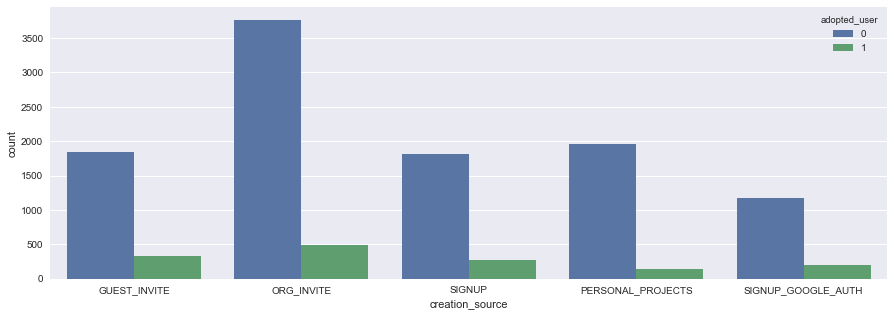

In [20]:
from matplotlib import pyplot as plt
import seaborn as sns

sns.set()

plt.figure(figsize=(15, 5))
sns.countplot(x='creation_source', data=users, hue='adopted_user')
plt.show()

Slightly more people that are adopted users opted in to the mailing list than non-adopters (26.16% vs. 24.78%).  Mail list opt-ins may therefore be a predictor for adopted users, though perhaps not a significant one.  

In [21]:
percent_mailing_list = len(adopted[adopted['opted_in_to_mailing_list'] ==1])/len(adopted)
print("Opted in to mailing list, adopted: {:.2f} %".format(percent_mailing_list * 100))

adopted['opted_in_to_mailing_list'].value_counts()

Opted in to mailing list, adopted: 26.16 %


0    1067
1     378
Name: opted_in_to_mailing_list, dtype: int64

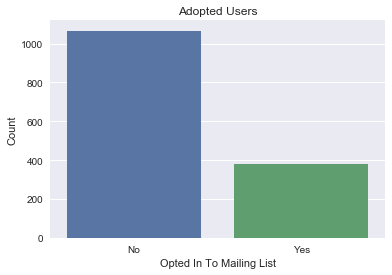

In [22]:
fig, ax = plt.subplots()
sns.countplot(x=adopted['opted_in_to_mailing_list'])
ax.set_xlabel('Opted In To Mailing List')
ax.set_xticklabels(['No', 'Yes'])
ax.set_ylabel('Count')
ax.set_title('Adopted Users')
plt.show()

In [23]:
percent_mailing_list = len(not_adopted[not_adopted['opted_in_to_mailing_list'] ==1])/len(not_adopted)
print("Opted in to mailing list, not adopted: {:.2f} %".format(percent_mailing_list * 100))


not_adopted['opted_in_to_mailing_list'].value_counts()

Opted in to mailing list, not adopted: 24.78 %


0    7939
1    2616
Name: opted_in_to_mailing_list, dtype: int64

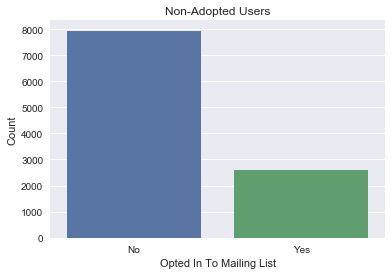

In [24]:
fig, ax = plt.subplots()
sns.countplot(x=not_adopted['opted_in_to_mailing_list'])
ax.set_xlabel('Opted In To Mailing List')
ax.set_xticklabels(['No', 'Yes'])
ax.set_ylabel('Count')
ax.set_title('Non-Adopted Users')
plt.show()

Slightly more people that are adopted users were enabled for the marketing drip than non-adopters (15.50% vs. 14.86%).  Given that this is such a small difference (less than 1%), the influence of the marketing drip may be negligible.  

In [25]:
percent_marketing_drip_1 = len(adopted[adopted['enabled_for_marketing_drip'] ==1])/len(adopted)
print("Enabled for marketing drip, adopted: {:.2f} %".format(percent_marketing_drip_1 * 100))

adopted['enabled_for_marketing_drip'].value_counts()

Enabled for marketing drip, adopted: 15.50 %


0    1221
1     224
Name: enabled_for_marketing_drip, dtype: int64

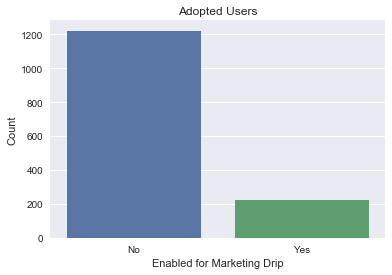

In [26]:
fig, ax = plt.subplots()
sns.countplot(x=adopted['enabled_for_marketing_drip'])
ax.set_xlabel('Enabled for Marketing Drip')
ax.set_xticklabels(['No', 'Yes'])
ax.set_ylabel('Count')
ax.set_title('Adopted Users')
plt.show()

In [27]:
percent_marketing_drip_2 = len(not_adopted[not_adopted['enabled_for_marketing_drip'] ==1])/len(not_adopted)
print("Enabled for marketing drip, not adopted: {:.2f} %".format(percent_marketing_drip_2 * 100))

not_adopted['enabled_for_marketing_drip'].value_counts()

Enabled for marketing drip, not adopted: 14.86 %


0    8987
1    1568
Name: enabled_for_marketing_drip, dtype: int64

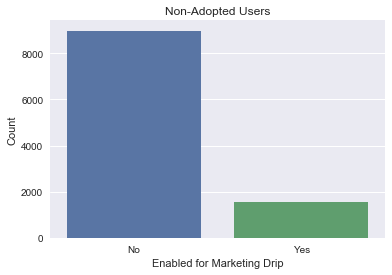

In [28]:
fig, ax = plt.subplots()
sns.countplot(x=not_adopted['enabled_for_marketing_drip'])
ax.set_xlabel('Enabled for Marketing Drip')
ax.set_xticklabels(['No', 'Yes'])
ax.set_ylabel('Count')
ax.set_title('Non-Adopted Users')
plt.show()

## Machine Learning

### Initial preparations

In order to prepare the data for use in a machine learning model, I extracted some additional features from the last_session_creation_time variable, namely the months the users last logged in (called month_logged_in), and whether it was in the am or pm hours of the day (am_pm, a binary variable). Slightly over 50% of users last logged in during pm hours, rather than am hours.  

I then determined that the invited_by_user_id category was unnecessary to include, noting that it was only null for those creation_sources that were not guest or organizational invites, so provided creation_source was included as a variable, invited_by_user_id would be unlikely to add any useful additional information.  

Finally, I converted the creation_source and month_logged_in categorical variables to dummy variables and included the following variables in the feature variables to be used in the model:  creation_source, month_logged_in, opted_in_to_mailing_list, enabled_for_marketing_drip and am_pm.  Adopted_user was used as the target variable.  

The feature and target variables were then split into training and test variables using an 80%-20% train-test split.

In [29]:
#Additional feature preparation/creation for model

#Look at months last logged in
users['month_logged_in'] = users['last_session_creation_time'].apply(lambda x: x.month)

In [30]:
#Create column indicating whether last login time was am or pm (0 or 1, respectively)

#More am or pm adopters?

users['am_pm'] = pd.Series([1 if i >= 12 else 0 for i in users['last_session_creation_time'].apply(lambda x: x.hour)])

In [31]:
print(users['am_pm'].value_counts())

print("Percentage logged in during pm hours: {:.2f} %".format((len(users[users['am_pm'] == 1])/len(users)) * 100))

1    6021
0    5979
Name: am_pm, dtype: int64
Percentage logged in during pm hours: 50.18 %


In [32]:
#No need to include invited_by_user_id as factor--creation_source values should account for this

users[(users['creation_source'] != 'GUEST_INVITE') & (users['creation_source'] != 'ORG_INVITE')]['invited_by_user_id'].value_counts()


Series([], Name: invited_by_user_id, dtype: int64)

In [33]:
#Convert creation_source to dummy variables
X = users
X = pd.get_dummies(X, columns=['creation_source', 'month_logged_in'], drop_first=True)
X.head()

,object_id,creation_time,name,email,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted_user,...,month_logged_in_3,month_logged_in_4,month_logged_in_5,month_logged_in_6,month_logged_in_7,month_logged_in_8,month_logged_in_9,month_logged_in_10,month_logged_in_11,month_logged_in_12
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,2014-04-22 03:53:30,1,0,11,10803.0,0,...,0,1,0,0,0,0,0,0,0,0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,2014-03-31 03:45:04,0,0,1,316.0,1,...,1,0,0,0,0,0,0,0,0,0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,2013-03-19 23:14:52,0,0,94,1525.0,0,...,1,0,0,0,0,0,0,0,0,0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,2013-05-22 08:09:28,0,0,1,5151.0,0,...,0,0,1,0,0,0,0,0,0,0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,2013-01-22 10:14:20,0,0,193,5240.0,0,...,0,0,0,0,0,0,0,0,0,0


In [34]:
#Drop unneeded columns from X and create y (target) variable

X = X.drop(['adopted_user', 'object_id', 'creation_time', 'name', 'email', 'last_session_creation_time', 
            'org_id', 'invited_by_user_id'], axis=1)
y = users['adopted_user']


In [35]:
#Get 80-20 train-test split of feature and target data
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Random Forest Classifier

I then created a simple Random Forest Classifier using 100 estimators to which I fit the training data.  It yielded a reasonably good accuracy of 86.79% on the test data.  

I then extracted the feature_importances which revealed that the two most important features in determining product adoption were logins in the months of June and May (month_logged_in_6 and month_logged_in_5, in that order). Of additional, though lesser, importance were (in descending order of importance):  opt-ins to the mailing list, creation sources from personal projects, whether the individuals were enabled for the marketing drip and whether the last log in was during am or pm hours. 


In [36]:
#Use random forest classifier with 100 estimators

from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(n_estimators=100, random_state=42)

rfc.fit(X_train, y_train)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [37]:
#Print accuracy of random forest
print("Accuracy: {:.2f} %".format(rfc.score(X_test, y_test) * 100))

Accuracy: 86.79 %


In [38]:
#Create dictionary of features and their importances
features = {}
for i in np.arange(0, len(X.columns)):
    features[X.columns[i]] = rfc.feature_importances_[i]
    

In [39]:
#Show feature importances--Best is logins in the month of June

for k, v in features.items():
    print(k, ": {:.4f}".format(v)) 
  
 
best_feature = list(features.keys())[list(features.values()).index(max(list(features.values())))]
print("\n")
print("Best feature: {:}".format(best_feature))


opted_in_to_mailing_list : 0.0372
enabled_for_marketing_drip : 0.0368
am_pm : 0.0325
creation_source_ORG_INVITE : 0.0194
creation_source_PERSONAL_PROJECTS : 0.0369
creation_source_SIGNUP : 0.0172
creation_source_SIGNUP_GOOGLE_AUTH : 0.0260
month_logged_in_2 : 0.0092
month_logged_in_3 : 0.0122
month_logged_in_4 : 0.0129
month_logged_in_5 : 0.1880
month_logged_in_6 : 0.5145
month_logged_in_7 : 0.0078
month_logged_in_8 : 0.0126
month_logged_in_9 : 0.0085
month_logged_in_10 : 0.0094
month_logged_in_11 : 0.0102
month_logged_in_12 : 0.0089


Best feature: month_logged_in_6


## Conclusions

In conclusion, it appears that the last month logged in appears to be the best predictor of user adoption of the product.  

From one perspective, the best times to target customers may be in the months of June and May during pm hours, as these are the times that users who adopt the product are most likely to have last logged in. Conversely, it could also be argued that the other months should be targeted more, since these are the times when those who are less likely to adopt appear to have last logged in.  Perhaps additional customer outreach during these times might serve to increase adoption rates during these months.   

It also appears that customers should be encouraged to opt in to the mailing list and enable themselves for the marketing drip, since adoption of the product appears to be slightly more likely in these cases.  Finally, based on the statistical analysis above, customers who signed up as a result of guest invites may also be slightly more likely to adopt the product, although this did not appear to be a strongly influential factor.  
